# Computer Vision: Segmentation Script



# Importing packages

In [1]:
# Importing packages
from lxml import etree
import numpy as np
import os
from skimage import io
from skimage.transform import resize
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import cv2
from random import randint
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Convolution2D
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Activation, Reshape, Permute
from keras.models import Model, Sequential, load_model
from keras.utils import to_categorical
print('importing finished')

Using TensorFlow backend.


importing finished


# 4. Segmentation

In [2]:
# Prepare segmentation data
def get_pascal_labels():
    """Load the mapping that associates pascal classes with label colors
    Returns:
    np.ndarray with dimensions (21, 3)
    """
    return np.asarray([
        [0, 0, 0],
        [128, 0, 0],
        [0, 128, 0],
        [128, 128, 0],
        [0, 0, 128],
        [128, 0, 128],
        [0, 128, 128],
        [128, 128, 128],
        [64, 0, 0],
        [192, 0, 0],
        [64, 128, 0],
        [192, 128, 0],
        [64, 0, 128],
        [192, 0, 128],
        [64, 128, 128],
        [192, 128, 128],
        [0, 64, 0],
        [128, 64, 0],
        [0, 192, 0],
        [128, 192, 0],
        [0, 64, 128],
        ])


def encode_segmap(mask, n_labels):
    """Encode segmentation label images as pascal classes
    Args:
        mask (np.ndarray): raw segmentation label image of dimension
            (M, N, 3), in which the Pascal classes are encoded as colours.
    Returns:
        (np.ndarray): class map with dimensions (M,N), where the value at
        a given location is the integer denoting the class index.
    """
    mask = mask.astype(int)
    label_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int16)
    labels = get_pascal_labels()
    for ii, label in enumerate(labels):
        label_mask[np.where(np.all(mask == label, axis=-1))[:2]] = ii
    label_mask = label_mask.astype(int)
    label_ohe_mask = np.zeros((mask.shape[0], mask.shape[1], n_labels))
    for i in range(label_mask.shape[0]):
        for j in range(label_mask.shape[1]):
            label_ohe_mask[i,j, label_mask[i,j]] = 1
    return label_ohe_mask


def create_binary_segmap(mask):
    mask = np.sum(mask[:,:,0:3], axis=-1)
    temp_mask = np.zeros((mask.shape[0], mask.shape[1], 2))
    foreground = mask!=0
    background = mask==0
    temp_mask[:, :, 0] = foreground
    temp_mask[:, :, 1] = background
    return temp_mask
    

def OHE_with_background(image_size, n_labels, train_img_f, train_true_f):
    n_train = len(train_img_f)
    
    x_train = np.zeros((n_train, image_size, image_size, 3))
    y_train = np.zeros((n_train, image_size, image_size, n_labels))

    for i in range(n_train):
        x_train[i] = resize(io.imread(train_img_f[i]+'.JPG'), (image_size, image_size, 3))
        mask = io.imread(train_true_f[i]+'.png')
        mask = encode_segmap(mask, n_labels)
        y_train[i] = resize(mask,(image_size, image_size, n_labels))
    
    print('%i images from %i classes' %(x_train.shape[0], y_train.shape[3]))

    print(x_train.shape)
    print(y_train.shape)
    return x_train, y_train


def binary_seg_sets(image_size, img_f, truth_f):
    n_train = len(img_f)
    
    x_train = np.zeros((n_train, image_size, image_size, 3))
    y_train = np.zeros((n_train, image_size, image_size, 2))

    for i in range(n_train):
        x_train[i] = resize(io.imread(img_f[i]+'.JPG'), (image_size, image_size, 3))
        mask = io.imread(truth_f[i]+'.png')
        mask = create_binary_segmap(mask)
        y_train[i] = resize(mask,(image_size, image_size))
    
    print('%i images' %(x_train.shape[0]))

    print(x_train.shape)
    print(y_train.shape)
    return x_train, y_train


n_labels = 21 # 20 classes and background

root_dir = os.getcwd()
voc_root_folder = os.path.join(root_dir, 'VOCtrainval_11-May-2009/VOCdevkit')

image_size = 256

seg_dir = os.path.join(voc_root_folder, 'VOC2009/SegmentationClass/')
img_dir = os.path.join(voc_root_folder, 'VOC2009/JPEGImages/')
train_set = os.path.join(voc_root_folder, 'VOC2009/ImageSets/Segmentation/train.txt')
val_set = os.path.join(voc_root_folder, 'VOC2009/ImageSets/Segmentation/val.txt')
train_img_f = []
train_true_f = []
val_img_f = []
val_true_f = []
print('creating training set')
with open(train_set) as file:
    train_lines = file.read().splitlines()
    for lines in train_lines:
        train_img_f.append(os.path.join(img_dir, lines))
        train_true_f.append(os.path.join(seg_dir, lines))
x_train, y_train = binary_seg_sets(256, train_img_f, train_true_f)


print('creating validation set')
with open(val_set) as file:
    val_lines = file.read().splitlines()
    for lines in val_lines:
        val_img_f.append(os.path.join(img_dir, lines))
        val_true_f.append(os.path.join(seg_dir, lines))

x_val, y_val = binary_seg_sets(256, val_img_f, val_true_f)

creating training set


KeyboardInterrupt: 

In [ ]:
mask = io.imread(val_true_f[0]+'.png')
print(mask.shape)
plt.figure()
plt.imshow(mask[:,:,3])
print(mask[1,2])
mask = np.sum(mask[:,:,0:3], axis=-1)
foreground = mask!=0
background = mask==0
print(background)
plt.figure()
plt.imshow(foreground, cmap='gray')


In [ ]:
def dice_coeff(y_true, y_pred):
    
    y_pred = keras.backend.max(y_pred, axis=-1, keepdims=True)
    y_pred = keras.backend.sign(y_pred)
    
    y_true = keras.backend.max(y_true, axis=-1, keepdims=True)
    y_true = keras.backend.sign(y_true)
    
    smooth = keras.backend.epsilon()
    intersec = y_true * y_pred
    intersec = keras.backend.sum(y_true * y_pred)
    som = keras.backend.sum(y_pred) + keras.backend.sum(y_true)
    return 1-((2.0*intersec + smooth)/(som + smooth))

def dice_coeffv2(y_true, y_pred):
  
    y_true = keras.backend.flatten(y_true)
    y_pred = keras.backend.flatten(y_pred)
    
    smooth = keras.backend.epsilon()
    intersec = keras.backend.sum(y_true * y_pred)
    som = keras.backend.sum(y_pred) + keras.backend.sum(y_true)
    print(som)
    print(intersec)
    return 1-(2.0*(intersec + smooth)/(som + smooth))

def dice_coefv3(y_true, y_pred):
    smooth = 0.0001
    y_true_f = keras.backend.flatten(y_true)
    y_pred_f = keras.backend.flatten(y_pred)
    intersection = keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (keras.backend.sum(y_true_f) + keras.backend.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coefv3(y_true, y_pred)

def dice_coefv4(y_true, y_pred):
    smooth = 0.0001
    y_true_f = keras.backend.flatten(y_true[:, :, 0])
    y_pred_f = keras.backend.flatten(y_pred[:, :, 0])
    intersection = keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (keras.backend.sum(y_true_f) + keras.backend.sum(y_pred_f) + smooth)

def dice_coef_lossv2(y_true, y_pred):
    return (1-dice_coefv4(y_true, y_pred))**2

<tf.Operation 'PrintV2' type=PrintV2>

In [6]:
# Implementation of a SegNet architecture
# from: https://github.com/imlab-uiip/keras-segnet/blob/master/build_model.py
def segnet(n_labels, in_shape, loss_function = 'categorical_crossentropy'):
    kernel = 3
    encoding_layers = [
        Convolution2D(8, kernel, border_mode='same', input_shape=in_shape),
        BatchNormalization(),
        Activation('relu'),
        Convolution2D(8, kernel, border_mode='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(),

        Convolution2D(16, kernel, kernel, border_mode='same'),
        BatchNormalization(),
        Activation('relu'),
        Convolution2D(16, kernel, kernel, border_mode='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(),

        Convolution2D(32, kernel, kernel, border_mode='same'),
        BatchNormalization(),
        Activation('relu'),
        Convolution2D(32, kernel, kernel, border_mode='same'),
        BatchNormalization(),
        Activation('relu'),
        Convolution2D(32, kernel, kernel, border_mode='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(),

        Convolution2D(64, kernel, kernel, border_mode='same'),
        BatchNormalization(),
        Activation('relu'),
        Convolution2D(64, kernel, kernel, border_mode='same'),
        BatchNormalization(),
        Activation('relu'),
        Convolution2D(64, kernel, kernel, border_mode='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(),

        # Convolution2D(64, kernel, kernel, border_mode='same'),
        # BatchNormalization(),
        # Activation('relu'),
        # Convolution2D(64, kernel, kernel, border_mode='same'),
        # BatchNormalization(),
        # Activation('relu'),
        # Convolution2D(64, kernel, kernel, border_mode='same'),
        # BatchNormalization(),
        # Activation('relu'),
        # MaxPooling2D(),
    ]

    autoencoder = Sequential()
    autoencoder.encoding_layers = encoding_layers

    for l in autoencoder.encoding_layers:
        autoencoder.add(l)

    decoding_layers = [
        # UpSampling2D(),
        # Convolution2D(64, kernel, kernel, border_mode='same'),
        # BatchNormalization(),
        # Activation('relu'),
        # Convolution2D(64, kernel, kernel, border_mode='same'),
        # BatchNormalization(),
        # Activation('relu'),
        # Convolution2D(64, kernel, kernel, border_mode='same'),
        # BatchNormalization(),
        # Activation('relu'),

        UpSampling2D(),
        Convolution2D(64, kernel, kernel, border_mode='same'),
        BatchNormalization(),
        Activation('relu'),
        Convolution2D(64, kernel, kernel, border_mode='same'),
        BatchNormalization(),
        Activation('relu'),
        Convolution2D(32, kernel, kernel, border_mode='same'),
        BatchNormalization(),
        Activation('relu'),

        UpSampling2D(),
        Convolution2D(32, kernel, kernel, border_mode='same'),
        BatchNormalization(),
        Activation('relu'),
        Convolution2D(32, kernel, kernel, border_mode='same'),
        BatchNormalization(),
        Activation('relu'),
        Convolution2D(32, kernel, kernel, border_mode='same'),
        BatchNormalization(),
        Activation('relu'),

        UpSampling2D(),
        Convolution2D(32, kernel, kernel, border_mode='same'),
        BatchNormalization(),
        Activation('relu'),
        Convolution2D(32, kernel, kernel, border_mode='same'),
        BatchNormalization(),
        Activation('relu'),

        UpSampling2D(),
        Convolution2D(32, kernel, kernel, border_mode='same'),
        BatchNormalization(),
        Activation('relu'),
        Convolution2D(n_labels, 1, 1, border_mode='valid'),
        BatchNormalization(),
        Activation('softmax')
    ]
    autoencoder.decoding_layers = decoding_layers
    for l in autoencoder.decoding_layers:
        autoencoder.add(l)

    autoencoder.compile(loss=loss_function, optimizer='SGD', metrics=['accuracy'])
    return autoencoder

In [ ]:
def auto_seg(n_labels, in_shape, loss_function = 'categorical_crossentropy'):
    input_img = Input(shape=in_shape)  # 196,608-dimensional
    x = Conv2D(16, (3, 3), activation='relu', padding='same', data_format='channels_last', kernel_initializer='normal')(input_img)
    x = MaxPooling2D((2, 2), padding='same', data_format='channels_last')(x)    # (128, 128, 16)    262,144-dimensional
    x = Conv2D(32, (3, 3), activation='relu', padding='same', data_format='channels_last', kernel_initializer='normal')(x)
    x = MaxPooling2D((2, 2), padding='same', data_format='channels_last')(x)    # (64, 64,32)       23,328-dimensional
    x = Conv2D(64, (3, 3), activation='relu', padding='same', data_format='channels_last', kernel_initializer='normal')(x)
    x = MaxPooling2D((2, 2), padding='same', data_format='channels_last')(x)    # (32, 32, 64)       5,832-dimensional
    x = Conv2D(128, (3, 3), activation='relu', padding='same', data_format='channels_last', kernel_initializer='normal')(x)
    encoded = MaxPooling2D((2, 2), padding='same', data_format='channels_last')(x)  # (16, 16, 128)     128-dimensional

    x = Conv2D(128, (3, 3), activation='relu', padding='same', data_format='channels_last', kernel_initializer='normal')(encoded)
    x = UpSampling2D((2, 2))(x)                                                 # (32, 32, 1288)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', data_format='channels_last', kernel_initializer='normal')(x)
    x = UpSampling2D((2, 2))(x)                                                 # (64, 64, 64)
    x = Conv2D(32, (3, 3), activation='relu', padding='same', data_format='channels_last', kernel_initializer='normal')(x)
    x = UpSampling2D((2, 2))(x)                                                 # (128, 128, 32)
    x = Conv2D(32, (3, 3), activation='relu', padding='same', data_format='channels_last', kernel_initializer='normal')(x)
    x = UpSampling2D((2, 2))(x)                                                 # (256, 256, 32)
    decoded = Conv2D(n_labels, (3, 3), activation='softmax', padding='same', data_format='channels_last', kernel_initializer='normal')(x)
    auto_seg = Model(input_img, decoded)
    auto_seg.compile(optimizer='SGD', loss=loss_function, metrics=['accuracy'])
    return auto_seg


In [ ]:
n_labels = 2 # 21 for 20 classes and background 2 when using binary images

net = auto_seg(n_labels, in_shape = (256, 256, 3), loss_function = dice_coef_lossv2)
net.summary()
custom_callbacks = [
                keras.callbacks.History(),
                keras.callbacks.CSVLogger(os.path.join(root_dir, 'auto_SegmentationTest_log_dice2.csv'), separator=',', append=False)]
net.fit(x_train, y_train, epochs=50, batch_size=32, shuffle=True, validation_data=(x_val, y_val), callbacks=custom_callbacks)
net.save(os.path.join(root_dir,'SegTest_dice2.h5'))

# Visualisation

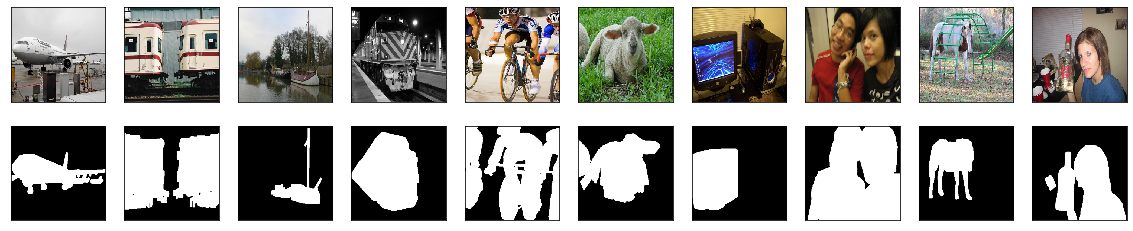

In [9]:
# Visualise sets
val_truth = y_val[:, :, :, 0]
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_val[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(val_truth[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [7]:
# Visualise results
n = 10

net_dice2 = load_model('SegTest_dice2.h5', {'dice_coef_lossv2': dice_coef_lossv2})
net_dice = load_model('SegTest_dice.h5', {'dice_coef_loss': dice_coef_loss})
net_cros = load_model('SegTest.h5')

prediction_dice = net_dice.predict(x_val[:n])
prediction_dice2 = net_dice2.predict(x_val[:n])
prediction_cros = net_cros.predict(x_val[:n])

prediction_dice = prediction_dice[:, :, :, 0]
prediction_dice2 = prediction_dice2[:, :, :, 0]
prediction_cros = prediction_cros[:, :, :, 0]
val_truth = y_val[:, :, :, 0]



NameError: name 'dice_coef_lossv2' is not defined

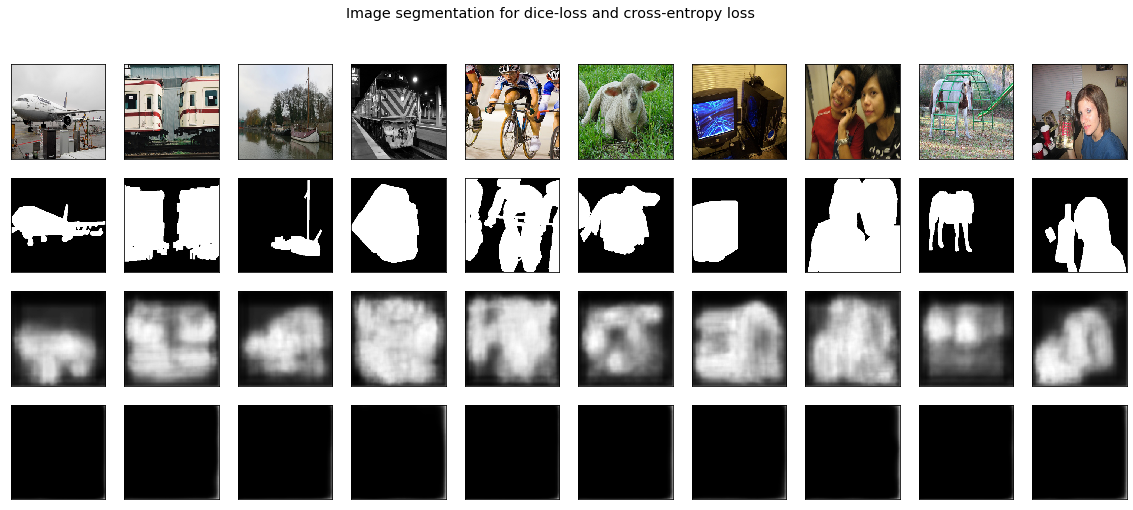

In [11]:
fig = plt.figure(figsize=(20, 8))
for i in range(n):
    # display original
    ax = plt.subplot(4, n, i+1)
    plt.imshow(x_val[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display truth
    ax = plt.subplot(4, n, i + n + 1)
    plt.imshow(val_truth[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display cross entropy
    ax = plt.subplot(4, n, i + 2*n + 1)
    plt.imshow(prediction_cros[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display dice
    ax = plt.subplot(4, n, i + 3*n + 1)
    plt.imshow(prediction_dice2[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.suptitle("Image segmentation for dice-loss and cross-entropy loss", fontsize="x-large")
plt.show()

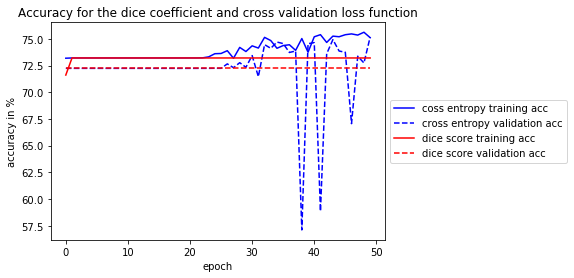

cross entropy =  75.1748616695404 at epoch  49
Dice score =  72.24050094286599 0


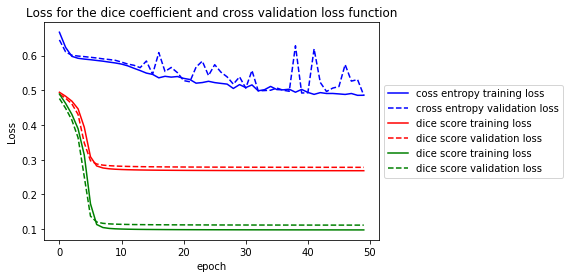

cross entropy =  0.4852932178974152 at epoch  49
Dice score =  0.2780022965669632 49


In [5]:
# Create history plots
import pandas as pd

cols = ['epoch', 'acc', 'loss', 'val_acc', 'val_loss']

dice = pd.read_csv("auto_SegmentationTest_log_dice.csv") 
dice2 = pd.read_csv("auto_SegmentationTest_log_dice2.csv") 
cros = pd.read_csv("auto_SegmentationTest_log.csv") 
fig = plt.figure()
plt.plot(cros['acc']*100, color='b', label = 'coss entropy training acc')
plt.plot(cros['val_acc']*100, color='b', linestyle='dashed', label = 'cross entropy validation acc' )
plt.plot(dice['acc']*100, color='r', label = 'dice score training acc')
plt.plot(dice['val_acc']*100, color='r', linestyle='dashed', label = 'dice score validation acc')
plt.xlabel('epoch')
plt.ylabel('accuracy in %')
plt.title('Accuracy for the dice coefficient and cross validation loss function')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()
print('cross entropy = ', max(cros['val_acc'])*100, 'at epoch ', np.argmax(cros['val_acc']))
print('Dice score = ', max(dice['val_acc'])*100, np.argmax(dice['val_acc']))

fig = plt.figure()
plt.plot(dice['loss'], color='r', label = 'one-hot encoding training loss')
plt.plot(dice['val_loss'], color='r', linestyle='dashed', label = 'dice score validation loss')
plt.plot(dice2['loss'], color='g', label = 'dice score training loss')
plt.plot(dice2['val_loss'], color='g', linestyle='dashed', label = 'dice score validation loss')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Loss for the dice coefficient')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()
print('cross entropy = ',min(cros['val_loss']), 'at epoch ', np.argmin(cros['val_loss']))
print('Dice score = ', min(dice['val_loss']), np.argmin(dice['val_loss']))

In [6]:
tresh = 0.01
prediction_dice2[prediction_dice2>tresh]=1
prediction_dice2[prediction_dice2<tresh]=0

prediction_cros[prediction_cros>tresh]=1
prediction_cros[prediction_cros<tresh]=0
fig = plt.figure(figsize=(20, 8))
for i in range(n):
    # display original
    ax = plt.subplot(4, n, i+1)
    plt.imshow(x_val[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display truth
    ax = plt.subplot(4, n, i + n + 1)
    plt.imshow(val_truth[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display cross entropy
    ax = plt.subplot(4, n, i + 2*n + 1)
    plt.imshow(prediction_cros[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display dice
    ax = plt.subplot(4, n, i + 3*n + 1)
    plt.imshow(prediction_dice2[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.suptitle("Image segmentation for dice-loss and cross-entropy loss", fontsize="x-large")
plt.show()

NameError: name 'prediction_dice2' is not defined